<a href="https://colab.research.google.com/github/ssvakil/Machine-Learning-in-Python-Workshop/blob/master/adaboost%202%20old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

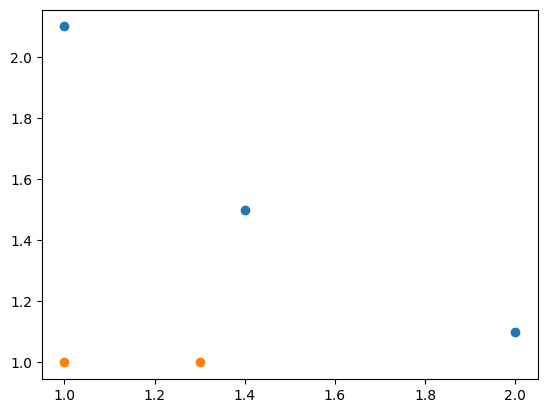

[INFO]point[-1,0], point[3,4] classified as: -1, 1


In [2]:


import numpy as np
import matplotlib.pyplot as plt

def loadDataset():
    datMat = np.matrix([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 1.4 , 1.5 ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#just classify the data
    retArray = -np.ones((np.shape(dataMatrix)[0],1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = 1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = 1.0
    return retArray

def buildStump(dataArr,classLabels,D):
    dataMatrix = np.mat(dataArr); labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = np.mat(np.zeros((m,1)))
    minError = np.inf #init error sum, to +infinity
    for i in range(n):#loop over all dimensions
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max();
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            for inequal in ['lt', 'gt']: #go over less than and greater than
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)#call stump classify with i, j, lessThan
                errArr = np.mat(np.ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T*errArr  #calc total error multiplied by D
                #print "split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError)
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst

def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m,1))/m)   #init D to all equal
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
        #print(f"D: {D.T}")
        alpha = float(0.5*np.log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
        #print(f"classEst: {classEst.T}")
        expon = np.multiply(-1*alpha*np.mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = np.multiply(D,np.exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
        #print(f"aggClassEst:, {aggClassEst.T})
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T,np.ones((m,1)))
        errorRate = aggErrors.sum()/m
        #print(f"total error: {errorRate}")
        if errorRate == 0.0: break
    return weakClassArr,aggClassEst

def adaClassify(datToClass,classifierArr):
    dataMatrix = np.mat(datToClass)#do stuff similar to last aggClassEst in adaBoostTrainDS
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix,classifierArr[i]['dim'],\
                                 classifierArr[i]['thresh'],\
                                 classifierArr[i]['ineq'])#call stump classify
        aggClassEst += classifierArr[i]['alpha']*classEst
        #print(f"aggClassEst: {aggClassEst}")
    return np.sign(aggClassEst)

def showDataset(dataMat, labelMat):
    data_plus = []
    data_minus = []
    for i in range(len(dataMat)):
        if labelMat[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)
    data_minus_np = np.array(data_minus)
    plt.scatter(np.transpose(data_plus_np)[0], np.transpose(data_plus_np)[1])
    plt.scatter(np.transpose(data_minus_np)[0], np.transpose(data_minus_np)[1])
    plt.show()

if __name__ == '__main__':
    dataArr,classLabels = loadDataset()
    showDataset(dataArr,classLabels)
    weakClassArr, aggClassEst = adaBoostTrainDS(dataArr, classLabels)
    print(f"[INFO]point[-1,0], point[3,4] classified as: {int(adaClassify([[-1,0],[3,4]], weakClassArr)[0,0])}, {int(adaClassify([[-1,0],[3,4]], weakClassArr)[1,0])}")